This notebook will be a discovery of OpenAI GYM and an implementation of Value Iteration, Policy Iteration, Q-Learning

We used the Cliff Walking Environment (also from Sutton's book).

    Adapted from Example 6.6 (page 132) from Reinforcement Learning: An Introduction
    by Sutton and Barto:
    The board is a 4x12 matrix, with (using Numpy matrix indexing):
        [3, 0] as the start at bottom-left
        [3, 11] as the goal at bottom-right
        [3, 1..10] as the cliff at bottom-center
    Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward
    and a reset to the start. An episode terminates when the agent reaches the goal.

## A gentle start with OpenAI Gym

### Looking to the environment

The newest documentation of the Cliff Walking Environement https://www.gymlibrary.dev/environments/toy_text/cliff_walking/

First, you need to install the environment

In [26]:
!pip install gym

In [27]:
!pip install gym[toy_text]

In this section, we discover the basic functions of gym:
* reset the environment
* render the environment with 'rgb-array' mode
* access to the discret action space
* access to the state space

==========Load the environement==========
==========Visualize the environement==========
==========Action Space==========
There are 4 actions :
UP=0 RIGHT=1 DOWN=2 LEFT=3
==========State Space==========
There are 48 state
initial state is 36 and goal is 47


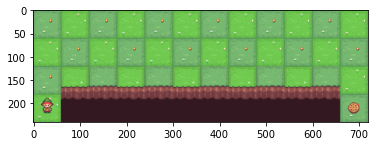

In [28]:
import gym
import numpy as np
from matplotlib import pyplot as plt
import time 
from gym.envs.toy_text import cliffwalking as cw

print("="*10 + "Load the environement"+"="*10)
env = gym.make('CliffWalking-v0',render_mode="rgb_array") # TO IMPLEMENT
env.reset()
print("="*10 + "Visualize the environement"+"="*10)

def show(env):

    img=env.render()
    plt.imshow(img)

show(env)

## Action Space
UP, RIGHT, DOWN, LEFT = cw.UP, cw.RIGHT, cw.DOWN, cw.LEFT
nb_actions = 4
print("="*10 + "Action Space"+"="*10)
print(f'There are {env.action_space.n} actions :')
print(f"{UP=} {RIGHT=} {DOWN=} {LEFT=}")
# print(None) # TO IMPLEMENT 

## State space
nb_states = env.observation_space.n
print("="*10 + "State Space"+"="*10)
print(f'There are {nb_states} state')
INIT_STATE = env.start_state_index
GOAL = nb_states - 1
print(f"initial state is {INIT_STATE} and goal is {GOAL}")

Observe a state space by sampling randomly from the action space

The initial observation is (36, {'prob': 1})
36 -1 False False {'prob': 1.0}
The new observation is 36


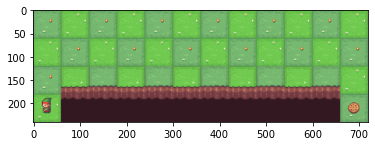

In [29]:
import matplotlib.pyplot as plt 

# reset the environment and see the initial observation
obs = env.reset()
print("The initial observation is {}".format(obs))

# Sample a random action from the entire action space
random_action = env.action_space.sample()

# # Take the action and get the new observation space
new_obs, reward,terminated, truncated, info  = env.step(random_action)
print(new_obs, reward,terminated, truncated, info)
show(env)
print("The new observation is {}".format(new_obs))

### Use of a random policy

Define a randpme policy and a go right plicy 

In [30]:
def RandomPolicy(state):
    random_action = env.action_space.sample()
    return random_action
    
def GoRightPolicy(state):
    return RIGHT


This function served to simulate the trajectory and plot the cummulated reward

In [54]:
def simulate_trajectory(T, Pi):
    """return a vector of T successive states and a vector of T successive rewards"""
    Rewards = np.zeros(T+1)
    States = np.zeros(T+1)
    env = gym.make('CliffWalking-v0', render_mode='rgb_array')
    state, _ = env.reset()
    for t in range(T):
        States[t] = state
        action = Pi(state)
        state, rew, terminated, _, _ = env.step(action)
        Rewards[t] = rew
        if terminated:
            print(f"terminated in {t} steps")
            break
    show(env)
    return States, Rewards

def plot_trajectory(policy, policy_name="policy", plot_States1=False):
    if callable(policy):
        policy_function = policy
    else:
        policy_function = lambda state: policy[state]
    gamma = 0.9  # discount factor
    # truncation of the infinite sum
    T = int(np.log(1/(0.001*(1-gamma)))/np.log(1/gamma))
    States1, Rewards1 = simulate_trajectory(T, policy_function)
    if plot_States1:
        print(States1)
    # plot cumulative discounted reward (on a single run):
    plt.figure()
    plt.plot(np.cumsum(
        Rewards1*np.array([gamma**t for t in range(T+1)])), label=policy_name)
    # print(States1)
    plt.xlabel('steps')
    plt.ylabel('cumulated discounted reward')
    plt.legend()
    plt.show()

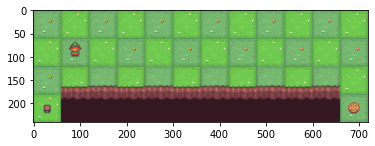

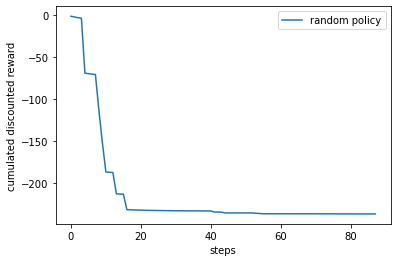

In [32]:
plot_trajectory(RandomPolicy, policy_name="random policy", plot_States1=False)

Here, we define the optimal policy (off-line)

In [33]:
def optimal_policy(state):
    if state == INIT_STATE:
        return UP
    elif state % 12 == 11:
        return DOWN
    else:
        return RIGHT

terminated in 12 steps


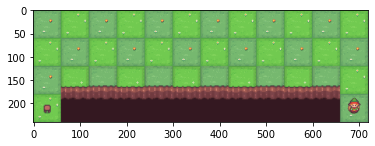

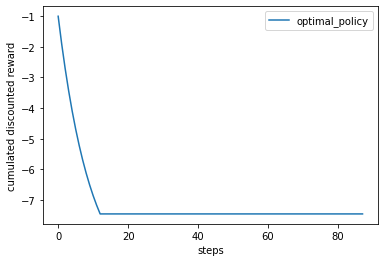

In [56]:
plot_trajectory(optimal_policy, policy_name="optimal_policy", plot_States1=False)

## Dynamic Programming

In order to use our dynamic programming algorithms, we need to know the parameters of the MDP. 
Here we know the reward and transition model. 

The 3D matrix P store the transitional model of a given state s, with a given action, to the next state s'
The 2D matrix r store the average reward in state s when playing action a  
<span style="color:red">When the agent arrive the final state, it should end, there will be no possibility to go to the next state, the reward is wero for the final state</span>


In [35]:
# MDP parameters
nb_states =48
nb_actions = 4
P = np.zeros((nb_states,nb_actions,nb_states)) # P[s,a,s'] = p(s' | s,a) 
r = np.zeros((nb_states,nb_actions)) # r[s,a] = average reward received in state s when playing action a
for state in range(nb_states):
    for action in range(nb_actions):
        prob, next_state, reward,_=env.P[state][action][0]
        P[state,action,:]=0.0
        P[state,action,next_state]=1.0
        r[state,action]=reward

P[GOAL,:,:]=0.0
r[GOAL,:]=0


### Policy Iteration

In this section, we will consider policies as a vector. A policy  is represented as a vector pi[s] with s a state. 

In [36]:
example_pi =  np.random.choice([0,1,2,3], nb_states)  # An example of random  policy

Let's start withthe policy evaluation step. 
The objective is to converge to the value function for a given policy pi 

Using the Bellman equations, build the evaluation of a policy. We consider convergence with $\epsilon = 0.01$ or if we performed a maximum of 10000 iterations.

In [37]:
def policy_evaluation(policy):
    V = np.zeros(nb_states) # intialize V to 0's
    epsilon =0.1
    max_iter = 10000
    gamma=0.9
    delta=epsilon
    evaluation_iterations = 1
    while delta>=epsilon and max_iter:
        v=V.copy()
        '''
        the first term signifies the reward for each state for a given policy (parameters already stored in the r table) -- vector
        the second term is the expected value function to the next state. P[np.arange(P.shape[0]),policy,:] given a matrix 
        size of (nb_state,nb_state), all the other value will be zero except the next state which decided by the policy. 
        The summation over each state by axis 1

        '''
        
        V=r[np.arange(r.shape[0]),policy]+gamma*(P[np.arange(P.shape[0]),policy,:]*V).sum(axis=1) 
        delta=np.abs(v-V).max()
        evaluation_iterations += 1
    print(f'Policy evaluated in {evaluation_iterations} iterations.')
    return V


This step we output a determnistic policy which will maximize the value function, if the policy is not converged, it will keep doing value iterations


In [38]:

def policy_improve(V,policy):

    improved_policy=(P*V).sum(axis=2).argmax(axis=1)
    if np.any(policy !=improved_policy):
        
        V=policy_evaluation(improved_policy)
        improved_policy =policy_improve(V,improved_policy)
    return improved_policy

    #P is of shape (48,4,48) V is of shape (48,) the product of P*V is also (48,4,38), the summation over axis 1 give 
    #a shape of (48,4), the argmax give the index of the best policy 
    #return policy
   


This fuction using the two preceding functions, build the Policy Iteration algorithm

In [39]:

def policy_iteration():
    policy= np.random.choice([0,1,2,3], nb_states)  # initialize with the random policy
    V=policy_evaluation(policy)
    policy=policy_improve(V,policy)

    return policy

Policy evaluated in 24 iterations.
Policy evaluated in 24 iterations.
Policy evaluated in 24 iterations.
Policy evaluated in 24 iterations.
Policy evaluated in 24 iterations.
Policy evaluated in 24 iterations.
Policy evaluated in 24 iterations.
Policy evaluated in 24 iterations.
Policy evaluated in 24 iterations.
Policy evaluated in 24 iterations.
Policy evaluated in 24 iterations.
Policy evaluated in 24 iterations.
Policy evaluated in 24 iterations.
Policy evaluated in 24 iterations.
Policy evaluated in 16 iterations.
terminated in 12 steps


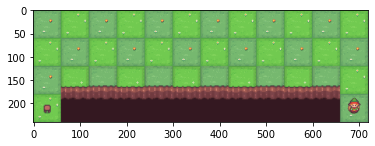

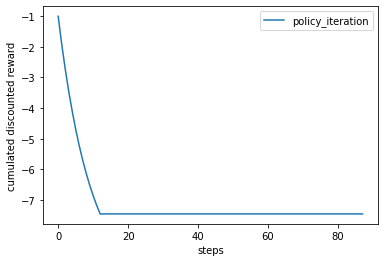

In [40]:
policy_iter=policy_iteration()
plot_trajectory(policy_iter, policy_name="policy_iteration", plot_States1=False)

### Value Iteration

The value iteration is easier to implement, in each iteration, it outputs a deterministic policy which maximize the value function. Iterate over each state until it converges. 

In [41]:
def value_iteration():
    V = np.zeros(nb_states)  # initialize V to 0's
    states = np.arange(nb_states)
    gamma = 0.9
    epsilon = 0.1
    delta = epsilon
    max_iter = 10000
    evaluation_iterations=1
    while delta >= epsilon and max_iter:
        v = V.copy()
        PV_sum = (P*V).sum(axis=2)
        actions = PV_sum.argmax(axis=1)  # get the best actions (argmax)
        V = (r + gamma*PV_sum)[states, actions]
        delta = np.abs(v-V).max()
        max_iter -= 1
        evaluation_iterations += 1
    print(f'Policy evaluated in {evaluation_iterations} iterations.')

    return V, actions

Policy evaluated in 16 iterations.
terminated in 12 steps


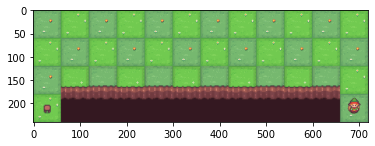

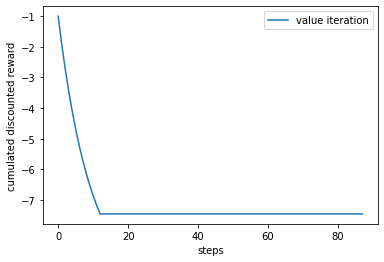

In [42]:
_, value_iter=value_iteration()
plot_trajectory(value_iter, policy_name="value iteration", plot_States1=False)

### Evaluate the two method

In [49]:
%%time
state, value_iter=value_iteration()

Policy evaluated in 16 iterations.
CPU times: user 2.95 ms, sys: 5.07 ms, total: 8.03 ms
Wall time: 7.74 ms


In [50]:
%%time
policy_iter=policy_iteration()

Policy evaluated in 24 iterations.
Policy evaluated in 24 iterations.
Policy evaluated in 24 iterations.
Policy evaluated in 24 iterations.
Policy evaluated in 24 iterations.
Policy evaluated in 24 iterations.
Policy evaluated in 24 iterations.
Policy evaluated in 24 iterations.
Policy evaluated in 24 iterations.
Policy evaluated in 24 iterations.
Policy evaluated in 24 iterations.
Policy evaluated in 24 iterations.
Policy evaluated in 24 iterations.
Policy evaluated in 16 iterations.
CPU times: user 24.1 ms, sys: 3.36 ms, total: 27.4 ms
Wall time: 30.7 ms


Now we don't have access to the Reward and Transitions table anymore ! We will have to explore to build our knowledge of the action-value Q(s,a) along the way.

Implement the Q-Learning algorithm. We will store action-value information in a table q[s,a]. 

We will need :
- a function act() to act in the environement 
- a function update() to learn the optimal actions and improve your knowledge of q.
- a function train() that use both precedent functions.


In [61]:
q = np.zeros([nb_states, nb_actions])
epsilon=0.2 # the greedy rate
alpha=1e-1 # learning rate
gamma=0.9

def act(state): # TO COMPLETE
    if np.random.binomial(1,epsilon): #exploit
        action =  np.argmax(q[state])
    else: #exploring
        action=np.random.choice([0,1,2,3])
    return action

def update(state,action,reward,state1,is_done):

    action1 = np.argmax(q[state1])
    Q_target = reward + gamma*(1-is_done)*q[state1, action1] #if you reach the goal, the q of the goal should be zero  --> the next action should be none
    q[state, action] = (1-alpha)*q[state, action] + alpha*Q_target
    

def train(env,n_iter):
    state=env.reset()[0]
    games_counter=0

    for t in range(n_iter):
        action = act(state)
        state1, reward, is_done, _,_ = env.step(action)
        update(state,action,reward,state1,is_done)
        state=state1
        if is_done:
            state=env.reset()[0] # it goes to 36
            games_counter+=1
    print(f'number of games played: {games_counter}')

        



In [62]:
%%time      
train(env,100000)
policy=q.argmax(axis=1)

number of games played: 341
CPU times: user 6.15 s, sys: 205 ms, total: 6.36 s
Wall time: 7.94 s


terminated in 12 steps


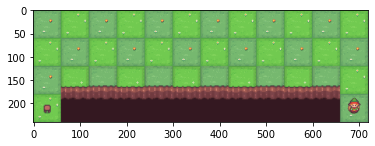

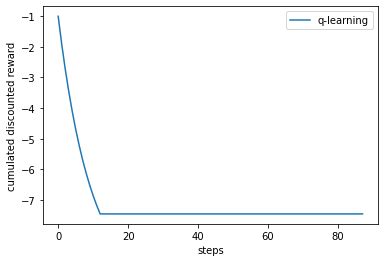

In [63]:
plot_trajectory(policy, policy_name="q-learning", plot_States1=False)